<a href="https://colab.research.google.com/github/LuigiSigillo/CartoonGAN/blob/main/CartoonGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [7]:
from google.colab import drive
import os
import json
import re
import cv2
import numpy as np
drive.mount('/content/drive')
#!unzip /content/drive/My\ Drive/NN/spirited_away.zip -d /content/drive/My\ Drive/NN/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/My\ Drive/NN/

paprika      spirited_away	your_name
paprika.zip  spirited_away.zip	your_name.zip


# Image Preprocessing

### Resizing images

In [ ]:
from PIL import Image
import os, sys



def resize(path):
    for item in os.listdir(path):
            im = Image.open(path+item)
            f, e = os.path.splitext(item)
            imResize = im.resize((256,256), Image.ANTIALIAS)
            print(f)
            imResize.save(path+"_resized/" + f + ' resized.jpg', 'JPEG', quality=90)

resize('/content/drive/My Drive/NN/your_name')

### Apply canny

scemo


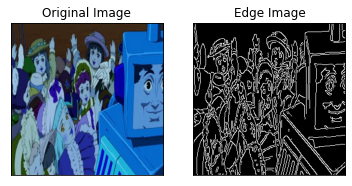

In [19]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread('/content/drive/My Drive/NN/paprika_resized/scene43626 resized.jpg')
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

### Apply canny and dilate

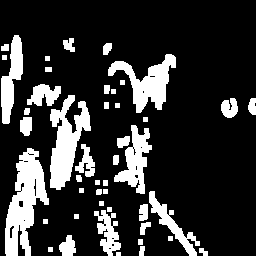

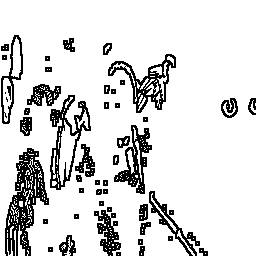

-1

In [23]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# read image
img = cv2.imread('/content/drive/My Drive/NN/paprika_resized/scene43626 resized.jpg')

# convert to gray
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# threshold
thresh = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)[1]

# morphology edgeout = dilated_mask - mask
# morphology dilate
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
dilate = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

# get absolute difference between dilate and thresh
diff = cv2.absdiff(dilate, thresh)

# invert
edges = 255 - diff

# write result to disk
'''cv2.imwrite("cartoon_thresh.jpg", thresh)
cv2.imwrite("cartoon_dilate.jpg", dilate)
cv2.imwrite("cartoon_diff.jpg", diff)
cv2.imwrite("cartoon_edges.jpg", edges)'''

# display it
cv2_imshow(dilate)
cv2_imshow(edges)

### Apply cannybia

Edge-smoothing of  /content/drive/My Drive/NN/paprika_resized/scene43626 resized.jpg


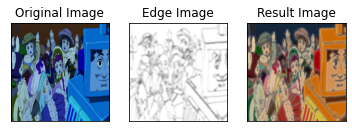

In [40]:
import os
import cv2
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt

def edge_smoothing(cartoon_images_filename, smoothed_images_filename):
    print("Edge-smoothing of ", cartoon_images_filename)
    origin = cv2.imread(cartoon_images_filename)
    edges = createEdgesOverlay(origin)
    result = overlayEdges(edges, origin)
    show_images(origin, edges, result)
    result.save(smoothed_images_filename, "JPEG")

def overlayEdges(edges, origin):
    background = transformFromCV2ToPillowImageFormat(origin)
    background.paste(edges, (0, 0), edges)
    background = background.convert("RGB")
    return background

def transformFromCV2ToPillowImageFormat(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    return Image.fromarray(img)

def createEdgesOverlay(origin):
    edges = cv2.Canny(origin, 30, 300, 3)
    edges = cv2.dilate(edges, (3, 3))
    edges = cv2.bitwise_not(edges)
    edges = transformFromCV2ToPillowImageFormat(edges)
    makeWhiteBackgroundTransparent(edges)
    edges = edges.filter(ImageFilter.GaussianBlur) #do blurring here because doing it before making background transparent results in white halo

    return edges

# got this from here:
# https://stackoverflow.com/questions/765736/using-pil-to-make-all-white-pixels-transparent/4531395
def makeWhiteBackgroundTransparent(img):
    datas = img.getdata()
    newData = []
    for item in datas:
        if item[0] == 255 and item[1] == 255 and item[2] == 255:
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)
    img.putdata(newData)

def show_images(img,edges,result):
    plt.subplot(131),plt.imshow(img)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(132),plt.imshow(edges)
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
    
    plt.subplot(133),plt.imshow(result)
    plt.title('Result Image'), plt.xticks([]), plt.yticks([])

    plt.show()

path_resized = "/content/drive/My Drive/NN/paprika_resized/"
path_smoothed = "/content/drive/My Drive/NN/paprika_resized_smoothed/"


#for filename in os.listdir(path_resized):
filename='scene43626 resized.jpg'
cartoon_images_filename = path_resized + filename
smoothed_images_filename = path_smoothed + filename
edge_smoothing(cartoon_images_filename, smoothed_images_filename)



# Valerio